In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# def variable
from torch.autograd import Variable

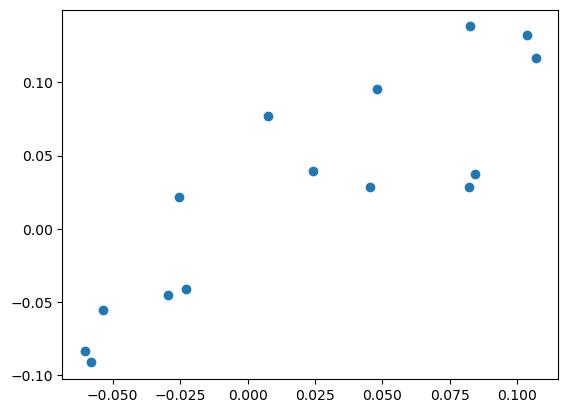

In [2]:
from src.models import LVGEBM
model = LVGEBM(15,4,10000)
y = model(model.z)
# plot y
y = y.detach().numpy()
plt.scatter(y[:,0],y[:,1])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


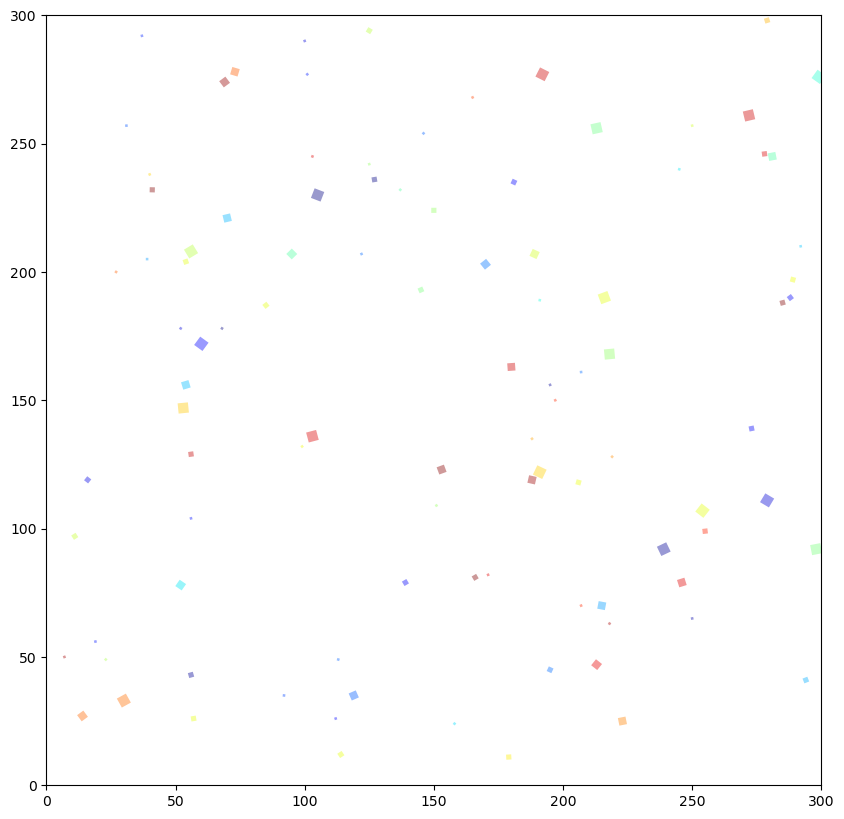

In [4]:
from src.utils.data import loadData

# load data
sq, qp = loadData(100)
print(sq[0])
from src import visualization as vis
vis.plot_data(sq,limits=[0,300,0,300])

In [5]:
from src.metrics import Linf
from src.ebmUtils import Reg, RegLatent, loss_functional

In [6]:
from src.train import trainTeacher

In [8]:
model = LVGEBM(4,2,400).to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 200
times = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = torch.from_numpy(sq).float().to(device)
alpha = 5
beta = 10
results = trainTeacher(model
                          , optimizer
                          , epochs
                          , times
                          , device
                          , train_data
                          , alpha
                          , beta
)

Training Teacher Model
Epoch: 20/200..  Training loss: 8749.05469..  Reg Proj: 0.00000..  Reg Latent: 0.47908..  Memory: 8744.26367..  Cost: 8749.05469.. 
Epoch: 40/200..  Training loss: 7278.27490..  Reg Proj: 0.00000..  Reg Latent: 0.40064..  Memory: 7274.26855..  Cost: 7278.27490.. 
Epoch: 60/200..  Training loss: 7465.73047..  Reg Proj: 0.00000..  Reg Latent: 1.10263..  Memory: 7454.70410..  Cost: 7465.73047.. 
Epoch: 80/200..  Training loss: 7712.10498..  Reg Proj: 0.00000..  Reg Latent: 0.10433..  Memory: 7711.06152..  Cost: 7712.10498.. 
Epoch: 100/200..  Training loss: 7922.92725..  Reg Proj: 0.00000..  Reg Latent: 1.73926..  Memory: 7905.53467..  Cost: 7922.92725.. 
Epoch: 120/200..  Training loss: 7719.07129..  Reg Proj: 0.00000..  Reg Latent: 0.48807..  Memory: 7714.19043..  Cost: 7719.07129.. 
Epoch: 140/200..  Training loss: 8581.44531..  Reg Proj: 0.00000..  Reg Latent: 0.48494..  Memory: 8576.59570..  Cost: 8581.44531.. 
Epoch: 160/200..  Training loss: 8668.90625..  Reg

best epoch:  42
best outputs:  tensor([[ 10.4374, 108.7062],
        [139.9694, 253.7553],
        [265.0951, 201.6465],
        [162.7002,  86.9601]], device='cuda:0', grad_fn=<AddBackward0>)
costs:  [20021.11328125, 19967.6015625, 12399.7216796875, 19940.044921875, 33327.59765625, 19536.5625, 17822.25390625, 19208.90625, 13642.7509765625, 18672.48046875, 23787.408203125, 17488.640625, 15625.4736328125, 16453.767578125, 16832.611328125, 13885.083984375, 16507.830078125, 9434.962890625, 6610.6611328125, 8749.0546875, 6340.9716796875, 8097.9296875, 7551.32470703125, 7127.09716796875, 6354.72021484375, 7262.14013671875, 6879.37109375, 7651.6484375, 6946.4814453125, 7859.26513671875, 8171.5947265625, 7545.1494140625, 7180.92236328125, 7609.7099609375, 7496.365234375, 8108.25341796875, 8210.708984375, 7175.24658203125, 6619.56298828125, 7278.27490234375, 7675.93603515625, 8290.8759765625, 5527.55615234375, 8165.99267578125, 6749.10791015625, 8383.4287109375, 8016.7783203125, 8507.682617187

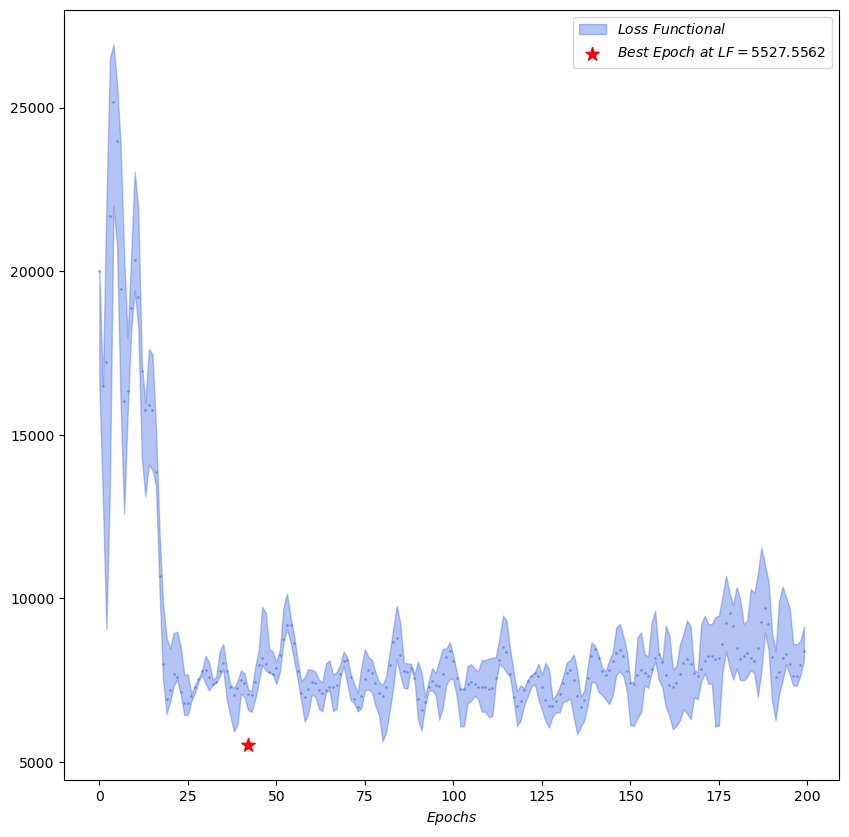

In [9]:
from src.utils.plot_tools import plot_AM_dem, AM_dem
best_outputs = results["best_outputs"]
best_epoch = results["best_epoch"]
costs = results["cost_array"]
print("best epoch: ", best_epoch)
print("best outputs: ", best_outputs)
print("costs: ", costs)
signal = costs
upper_signal, lower_signal, filtered_siganl = AM_dem(signal, fc=0.4*len(signal),fs=2*len(signal))
plot_AM_dem(upper_signal, lower_signal, filtered_siganl, signal, best_epoch)

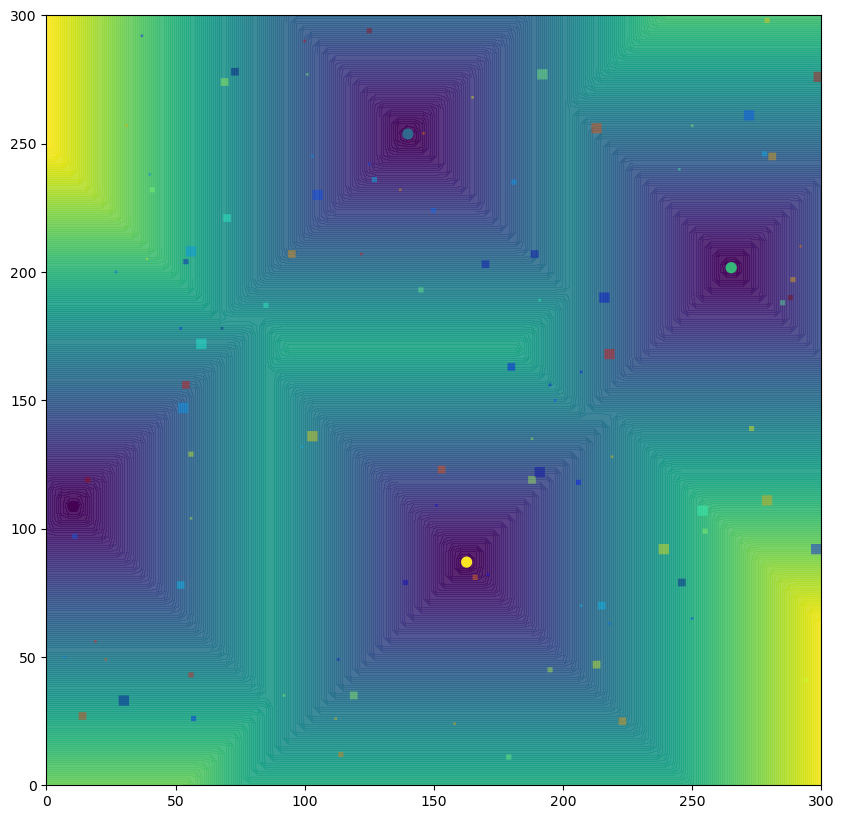

In [12]:
from src.utils import plot_tools as pt
manifold = pt.createManifold(model, best_outputs.cpu())
pt.plotManifold(sq, manifold, best_outputs.cpu(),[0,300],[0,300])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import src.geometry as geo
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def plot_data(fig,ax ,data, size=10, limits=[-10, 10, -10, 10]):
    """
        Plot the data points 

        Parameters:
            data: data to be plotted
            size: size of the plot
            limits: limits of the plot

        Returns:
            None
    """
    patches = []
    num_polygons = data.__len__()

    for i in range(num_polygons):
        square = geo.create_square2(data[i])
        # print(square.shape)
        polygon = Polygon(square, True)
        patches.append(polygon)

    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])


## VOr

In [ ]:
class Voronoi(nn.Module):
    def __init__(self, n_centroids, input_dim, output_dim):
        super(Voronoi, self).__init__()
        self.n_centroids = n_centroids
        self.input_dim = input_dim
        self.output_dim = output_dim
        # inputs are datapoints and outputs are energies
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_centroids)

        )

    def forward(self, x):
        x = self.predictor(x)
        return x
        
vor = Voronoi(10, 2, 2)
x = qp[0:3]
print(x.shape)
x = torch.tensor(x, dtype=torch.float32)
y = vor(x)
print(y.shape)

In [ ]:
torchsummary.summary(best_model)

In [ ]:
best_model.parameters.__sizeof__()

In [ ]:
vor.parameters().__sizeof__()

In [ ]:
qp = np.load('100qp.npy')
# permute qp
qp = np.random.permutation(qp)
qp = qp[:200]
qp = torch.tensor(qp)
def getE(model, best_outputs, qp):
    # get qp
    qp = torch.tensor(qp)
    # get outputs
    outputs = best_outputs
    outputs = torch.tensor(outputs)
    # make Linf between outputs points and qp (between them all)
    E = torch.zeros(outputs.shape[0], qp.shape[0])
    for i in range(outputs.shape[0]):
        for j in range(qp.shape[0]):
            E[i,j] = torch.max(torch.abs(outputs[i] - qp[j]))
    F, z = E.min(0)
    # now do the same for sq
    outputs = outputs.detach().numpy()
    sq_ = np.load('100sq.npy')
    E_sq = loss_functional(outputs, sq_, model)
    F_sq, z_sq = E_sq.min(1)
    
    return F, z, F_sq, z_sq

def NearestNeighbour(qp, sq):
    d_nn = np.inf
    z_nn = 0
    for i, square in enumerate(sq):
        d_nn_sq,_,_ = Linf(square, qp)
        if d_nn_sq <= d_nn:
            d_nn = d_nn_sq
            z_nn = i
    return d_nn, z_nn

def Accuracy(F, z, F_sq, z_sq, qp, sq):
    acc = 0
    for i in range(qp.shape[0]):
        # find nn of qp[i]
        d_nn, z_nn = NearestNeighbour(qp[i], sq)
        
        #print("d_nn: ", d_nn)
        #print("z_nn: ", z_nn)
        #print("z[i]: ", z[i])
        #print("z_sq[z_nn]: ", z_sq[z_nn])
        if z_sq[z_nn] == z[i]:
            acc += 1
    return acc/qp.shape[0]

F, z, F_sq, z_sq = getE(best_model,best_outputs, qp)


In [ ]:
#plot qp
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#labels are z
labels = z.cpu()
plt_qp = qp.cpu().detach().numpy()
ax.scatter(plt_qp[:,0], plt_qp[:,1], c=labels, s=50)
# plot best_outputs
plt_bo = best_outputs
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)
z_labels = z
plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

In [ ]:
F_ps[0]

In [ ]:
z_ps[0]

In [ ]:
qq

## DIST

In [ ]:
qs = pseudo_clusters[2][1]
Linf(qs, qq)

In [ ]:
print(NearestNeighbour(qq, pseudo_clusters[2]))

In [ ]:
print(qq)
print(pseudo_clusters[0][3])
print(pseudo_clusters[1][8])
print(pseudo_clusters[2][1])
print(pseudo_clusters[3][1])

In [ ]:
NearestNeighbour(qq, pseudo_clusters[2])

In [ ]:
# print qq
plt.scatter(qq[0], qq[1], c='r', s=100)
# print squares 3 8 1 1 of pseudo_classes
ls = ['r', 'g', 'b', 'y']
for i in range(4):
    square = geo.create_square2(pseudo_clusters[i][int(z_ps[0][i].item())] )
    plt.plot(square[:,0], square[:,1], c=ls[i], alpha=0.5, linestyle='dashed')
    # make axis equal
    plt.axis('equal')
    # set lim
    #plt.xlim([100,210])
    #plt.ylim([0,300])


In [ ]:
vor = Voronoi(4, 2, 2).to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

loss = nn.L1Loss()
qp = torch.tensor(qp)
optimizer = torch.optim.Adam(vor.parameters(), lr=1e-3)
epochs = 10000
squares = np.load('100sq.npy')
pseudo_clusters = []
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i])
F_l = []
z_l = []
cost_l = []
qp = torch.tensor(qp).to(device)
outputs = torch.zeros(qp.shape[0], n_centroids)
F_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
z_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
ce = nn.CrossEntropyLoss()
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))

for epoch in range(epochs):
    #qp = np.load('100qp.npy')
    # get 1000 random points from qp
    # shuffle data
    #qp = torch.tensor(qp)
    #qp = qp[torch.randperm(qp.shape[0])][:100]
    qp = torch.tensor(qp, dtype=torch.float32).to(device)
    # get outputs
    outputs = vor(qp)
    # get pseudo labels

    
    # pass outputs through a hard arg max
    F, z = outputs.min(1)
    F_ps_m, z_ps_m = F_ps.min(1)
    # send to device
    F_ps_m = F_ps_m.to(device)
    z_ps_m = z_ps_m.to(device)
    # clone to device
    #make values of z_ps_m to be round to nearest integer
    r_z = torch.round(z_ps_m)

    # get loss
    alpha = 100
    beta = 1000
    z = z.float()
    #bce_loss = nn.BCELoss()(z, z_ps_m)
    z_ = outputs
    # make z_ float
    z_ = z_.float()
    z_cost = ce(z_, z_ps_m)
    F_cost = loss(F, F_ps_m)
    # get z_cost where we only penalize the wrong z and not its distance
    #z_cost = penalty(z, r_z)
    #F_l.append(F_cost.item())
    z_l.append(z_cost)
    #cost = alpha*F_cost + beta*z_cost
    cost = 10*z_cost 
    cost_l.append(cost.item())
    # backward
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if epoch%2000 ==0:
        print("Epoch: ", epoch, "Cost: ", cost.item())
        # lets check acc
        acc = 0
        for i in range(qp.shape[0]):
            F_e, z_e = outputs[i].max(0)
            if z_e == z_ps_m[i]:
                acc += 1
        print("Acc: ", acc/qp.shape[0])

            


In [ ]:
e = 10
x1 = outputs[e]
x2 = torch.tensor([[1]]).to(device)
x3 = z_ps_m[e]
print(f'x1: {x1}')
print(f'label is: {x3}')
for i in range(4):
    nu = i
    x4 = torch.tensor(nu).to(device)
    print(ce(x1,x4))

In [ ]:
def penalty(z_hat,z_target):
    loss = 0
    for i in range(z_hat.shape[0]):
        if z_hat[i] != z_target[i]:
            loss += 1
    return loss

In [ ]:
#print F_l and z_l

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(F_l, label='F')
z_l_p  = []
for i in range(len(z_l)):
    z_l_p.append(z_l[i]*beta)
ax.plot(z_l_p, label='z')
c_l = []
for i in range(len(F_l)):
    c_l.append(F_l[i]+beta*z_l[i])
ax.plot(c_l, label='c')
ax.legend()
# set ylim
ax.set_ylim([0,200])
#ax.set_xlim([-1,epochs])
#ax.set_ylim([0,100])

In [ ]:
model = vor
# plot manifold
x_discr = 100
y_discr = 100
manifold = torch.zeros(x_discr, y_discr, 4)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], x_discr)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], y_discr)):
        manifold[i, j, :] = torch.Tensor([x, y, 0,0])

print(manifold.shape)
# break manifold to batches of nx2
manifold = manifold.view(-1, 4) # 10000x3 take -> 10000x2 (drop 3rd dim)
points = manifold[:, :2]
# add 2 more columns to points and make them 0
#points = torch.cat((points, torch.zeros(points.shape[0], 2)), 1)
# send to device
points = points.to(device)
print(points.shape)# run through the network
#outputs = p_p[-2]
E = vor(points)
F, z = E.max(1)
print("outputs.shape", outputs.shape)
#cost = criterion(outputs, points) # 400x2 cdot 15x2
#points = points.detach().numpy()
for i in range(manifold.shape[0]):
    manifold[i,-2] = F[i]
    manifold[i,-1] = z[i]
# reshape to 100x100x3
manifold = manifold.reshape(100,100,4)

In [ ]:
n = 500
print('points[n]: ',points[n])
print('E[n]: ', E[n])


In [ ]:
# import summary
import torchsummary
torchsummary.summary(best_model)

In [ ]:
from matplotlib import cm
manifold_plot = manifold.detach().numpy()
# plot manifold as contour
fig = plt.figure(figsize=(10,10))

#make 3d plot
ax = fig.add_subplot(111)
# plot class
level = 200
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], manifold_plot[:,:,-1], levels=level, cmap='viridis', alpha=0.6)
ax.contourf(manifold_plot[:,:,0], manifold_plot[:,:,1], m1[:,:,-1], levels=level, cmap='viridis', alpha=0.1)
# plot scatter of output = model(model.z)
o = best_outputs
# lb is 0,..,no
no = n_centroids
lb = np.linspace(0, no-1, no)
ax.scatter(o[:,0], o[:,1],c=lb, s=100)
# also plot qp
qp_p = qp.cpu().detach().numpy()
#labels = z.cpu().detach().numpy()
ax.scatter(qp_p[:,0], qp_p[:,1],c=labels, s=10)
# -1 is the noise
#no = n_centroids
#color = cm.coolwarm(np.linspace(0, 1, no))
#for i in range(no):
#    ax.scatter(qp_p[labels==i,0], qp_p[labels==i,1],c=color[i], s=10)
#ax.set_xlim([0,300])
#ax.set_ylim([0,300])
# also vis data
plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

In [ ]:
# show all z
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(z.cpu().detach().numpy(), F.cpu().detach().numpy(), s=50)